In [2]:
# Topic:        Project 3
# Subject:      Market Basket Analysis of Instacart - Classification
# Date:         04/09/2020
# Name:         yalin yener

In [3]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from collections import OrderedDict


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', None)



In [4]:
# Reading Files and Creating Data Frame
aisle = pd.read_csv("/Users/yalinyener/GitHub/yalinyener/Instacart/Data_Trim/aisles.csv")
departments = pd.read_csv("/Users/yalinyener/GitHub/yalinyener/Instacart/Data_Trim/departments.csv")
products = pd.read_csv("/Users/yalinyener/GitHub/yalinyener/Instacart/Data_Trim/products.csv")
orders = pd.read_csv("/Users/yalinyener/GitHub/yalinyener/Instacart/Data_Trim/orders_subset.csv")
order_products_prior = pd.read_csv('/Users/yalinyener/GitHub/yalinyener/Instacart/Data_Trim/order_products__prior_subset.csv')
order_products_train = pd.read_csv('/Users/yalinyener/GitHub/yalinyener/Instacart/Data_Trim/order_products__train_subset.csv')

In [5]:
print("aisle: ",aisle.shape)
print("departments: " ,departments.shape)
print("orders: ",orders.shape)
print("products: ",products.shape)
print("order_products_prior: ",order_products_prior.shape)
print("order_products_train: ",order_products_train.shape)

aisle:  (134, 2)
departments:  (21, 2)
orders:  (82683, 7)
products:  (49688, 4)
order_products_prior:  (793924, 4)
order_products_train:  (53704, 4)


In [6]:
order_products_train = order_products_train.merge(orders.drop('eval_set', axis=1), on='order_id')
order_products_prior = order_products_prior.merge(orders.drop('eval_set', axis=1), on='order_id')

In [7]:
user_product = (order_products_prior.groupby(['product_id','user_id'],as_index=False) 
                                          .agg({'order_id':'count'}) 
                                          .rename(columns={'order_id':'user_product_total_orders'}))

train_ids = order_products_train['user_id'].unique() 
df_X = user_product[user_product['user_id'].isin(train_ids)]
df_X.shape

(329806, 3)

In [8]:
train_carts = (order_products_train.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))

df_X = df_X.merge(train_carts, on='user_id')
df_X['in_cart'] = (df_X.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))

df_X.sample(5)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart
76684,47766,23061,2,"{28928, 27845, 33352, 18128, 30290, 24852, 391...",0
302605,43768,76286,1,"{22149, 32407, 2314, 6347, 41169, 2295, 697, 4...",0
250393,4605,71223,1,"{21635, 47626, 2450, 24852, 5013, 15895, 37145...",1
103312,15539,168907,1,"{5025, 48036, 46213, 30406, 29382, 47141, 8390...",0
216334,3376,79343,1,"{25824, 23236, 28934, 8174, 29487, 39408, 2113...",0


0    0.901945
1    0.098055
Name: in_cart, dtype: float64


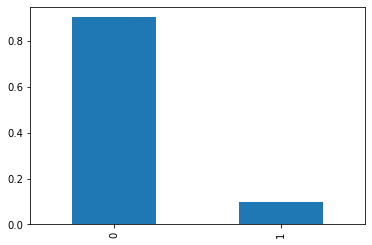

In [9]:
target_pcts = df_X.in_cart.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar')

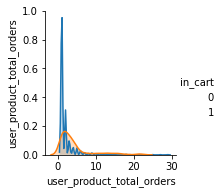

In [10]:
def plot_features(df, sample_size=500):
    
    sample = (df.drop(['product_id','user_id','latest_cart'],axis=1)
                .sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='in_cart', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(df_X)

In [11]:
# Slice data into faeture and target

X= df_X.drop(columns=["in_cart","latest_cart","product_id","user_id"])
y= df_X.loc[:,"in_cart"]

In [12]:
#Split data into train, test and validation (%80 - %20)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

In [13]:
classifiers = [
    LogisticRegression()
    ]

In [14]:
log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)
round(log,2)

LogisticRegression
****Results****
Accuracy: 90.2353%
Precision: 4.8283%
Recall: 45.4277%
F1 Score: 8.7289%
ROC AUC: 68.0642%
Log Loss: 0.3006


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,LogisticRegression,90.24,4.83,45.43,8.73,68.06,0.3


In [15]:
# Feature Engineering V2,Adding Product Features

prod_features = ['product_total_orders','product_avg_add_to_cart_order']
df_prod_features = (order_products_prior.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean')])))

df_prod_features.columns = ['product_id'] + prod_features

df_X = df_X.merge(df_prod_features, on='product_id')

X= df_X.drop(columns=["in_cart","latest_cart","product_id","user_id"])
y= df_X.loc[:,"in_cart"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

classifiers = [
    LogisticRegression(),
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log2 = log.append(log_entry)
    
print("="*30)
round(log2,2)

LogisticRegression
****Results****
Accuracy: 90.2429%
Precision: 5.2967%
Recall: 50.1471%
F1 Score: 9.5813%
ROC AUC: 70.4038%
Log Loss: 0.2954


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,LogisticRegression,90.24,5.3,50.15,9.58,70.4,0.3


In [16]:
# Feature Engineering V3,Adding User Features
user_features = ['user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order']

df_user_features = (order_products_prior.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id',['nunique', (lambda x: x.shape[0] / x.nunique())]),
                                                    ('product_id','nunique'),
                                                    ('days_since_prior_order','mean')])))

df_user_features.columns = ['user_id'] + user_features

df_X = df_X.merge(df_user_features, on='user_id')
df_X = df_X.dropna() # note that this is naive NaN handling for simplicity

X= df_X.drop(columns=["in_cart","latest_cart","product_id","user_id"])
y= df_X.loc[:,"in_cart"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

classifiers = [
    LogisticRegression(),
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log3 = log.append(log_entry)
    
print("="*30)
round(log3,2)

LogisticRegression
****Results****
Accuracy: 90.1458%
Precision: 7.7482%
Recall: 55.8952%
F1 Score: 13.6098%
ROC AUC: 73.2617%
Log Loss: 0.287


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,LogisticRegression,90.15,7.75,55.9,13.61,73.26,0.29


In [17]:
# Feature Engineering V4 Adding User-Product Features

user_prod_features = ['user_product_avg_add_to_cart_order']

df_user_prod_features = (order_products_prior.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('add_to_cart_order','mean')])))

df_user_prod_features.columns = ['product_id','user_id'] + user_prod_features 

df_X = df_X.merge(df_user_prod_features,on=['user_id','product_id'])
df_X['user_product_order_freq'] = df_X['user_product_total_orders'] / df_X['user_total_orders'] 


#Model V4
X= df_X.drop(columns=["in_cart","latest_cart","product_id","user_id"])
y= df_X.loc[:,"in_cart"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

classifiers = [
    LogisticRegression()]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log4 = log.append(log_entry)
    
print("="*30)

LogisticRegression
****Results****
Accuracy: 90.1565%
Precision: 7.8541%
Recall: 56.2297%
F1 Score: 13.7830%
ROC AUC: 73.4338%
Log Loss: 0.2867


In [18]:
# Feature Engineering V5, Adding Product Category

prod_dep = products.merge(departments, on="department_id")
prod_dep = prod_dep[["product_id","department"]]
df_X = df_X.merge(prod_dep,on="product_id")
df_X = pd.concat([df_X.drop('department',axis=1),pd.get_dummies(df_X["department"])],axis=1)

X= df_X.drop(columns=["in_cart","latest_cart","product_id","user_id"])
y= df_X.loc[:,"in_cart"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

classifiers = [
    LogisticRegression(),
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log5 = log.append(log_entry)
    
print("="*30)
round(log5,2)

LogisticRegression
****Results****
Accuracy: 90.2095%
Precision: 7.7593%
Recall: 54.8004%
F1 Score: 13.5938%
ROC AUC: 72.7573%
Log Loss: 0.2867


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,LogisticRegression,90.21,7.76,54.8,13.59,72.76,0.29


In [78]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log = log.append(log_entry)
print("="*30)
round(log,3)

LogisticRegression
****Results****
Accuracy: 90.2019%
Precision: 7.9120%
Recall: 54.4118%
F1 Score: 13.8152%
ROC AUC: 72.5689%
Log Loss: 0.2868
KNeighborsClassifier
****Results****
Accuracy: 88.6662%
Precision: 11.1807%
Recall: 30.5892%
F1 Score: 16.3758%
ROC AUC: 60.7208%
Log Loss: 2.24
DecisionTreeClassifier
****Results****
Accuracy: 84.1454%
Precision: 26.1952%
Recall: 23.3619%
F1 Score: 24.6976%
ROC AUC: 57.5596%
Log Loss: 5.476
RandomForestClassifier
****Results****
Accuracy: 90.4597%
Precision: 13.9911%
Recall: 58.0482%
F1 Score: 22.5477%
ROC AUC: 74.6511%
Log Loss: 0.3168
AdaBoostClassifier
****Results****
Accuracy: 90.4551%
Precision: 10.7530%
Recall: 60.8470%
F1 Score: 18.2762%
ROC AUC: 75.9154%
Log Loss: 0.6695
GradientBoostingClassifier
****Results****
Accuracy: 90.5294%
Precision: 12.6928%
Recall: 61.0132%
F1 Score: 21.0140%
ROC AUC: 76.0825%
Log Loss: 0.266
GaussianNB
****Results****
Accuracy: 81.6925%
Precision: 50.6950%
Recall: 27.2787%
F1 Score: 35.4708%
ROC AUC: 60.639

,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,LogisticRegression,90.202,7.912,54.412,13.815,72.569,0.287
0,KNeighborsClassifier,88.666,11.181,30.589,16.376,60.721,2.240
0,DecisionTreeClassifier,84.145,26.195,23.362,24.698,57.560,5.476
0,RandomForestClassifier,90.460,13.991,58.048,22.548,74.651,0.317
0,AdaBoostClassifier,90.455,10.753,60.847,18.276,75.915,0.669
0,GradientBoostingClassifier,90.529,12.693,61.013,21.014,76.082,0.266
0,GaussianNB,81.692,50.695,27.279,35.471,60.639,1.049


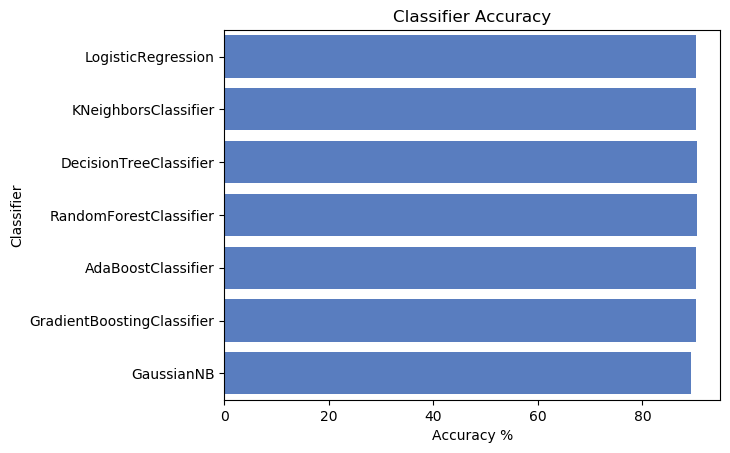

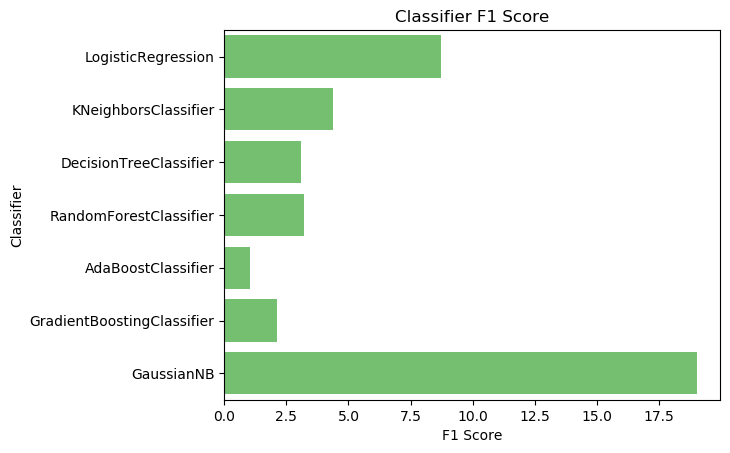

In [53]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()


sns.set_color_codes("muted")
sns.barplot(x='F1Score', y='Classifier', data=log, color="g")

plt.xlabel('F1 Score')
plt.title('Classifier F1 Score')

plt.show()

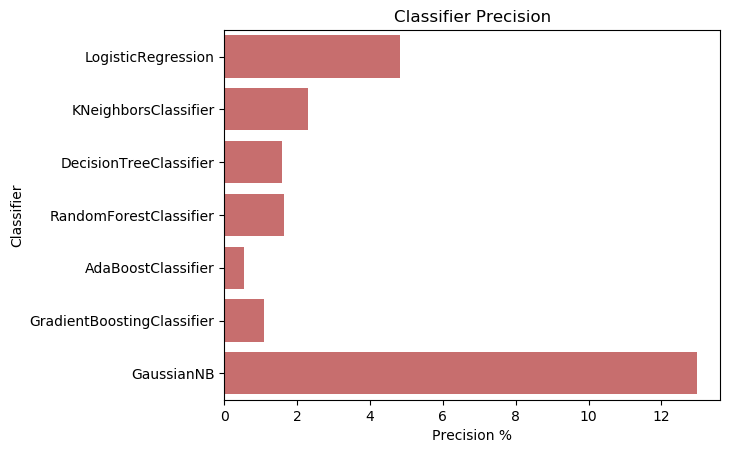

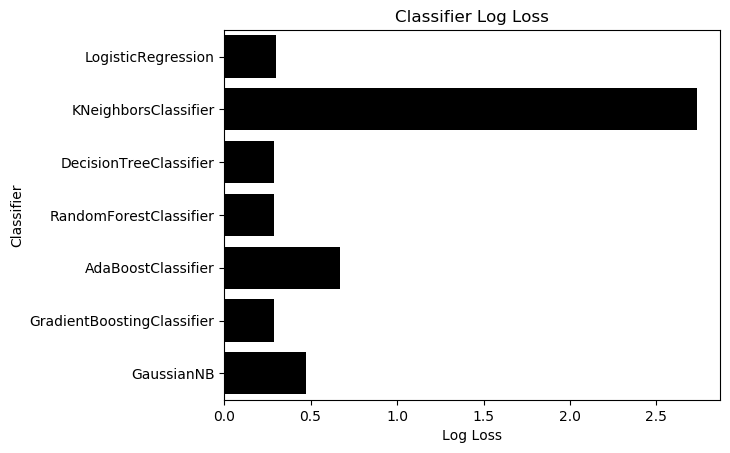

In [55]:
sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=log, color="r")

plt.xlabel('Precision %')
plt.title('Classifier Precision')
plt.show()


sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="black")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')

plt.show()

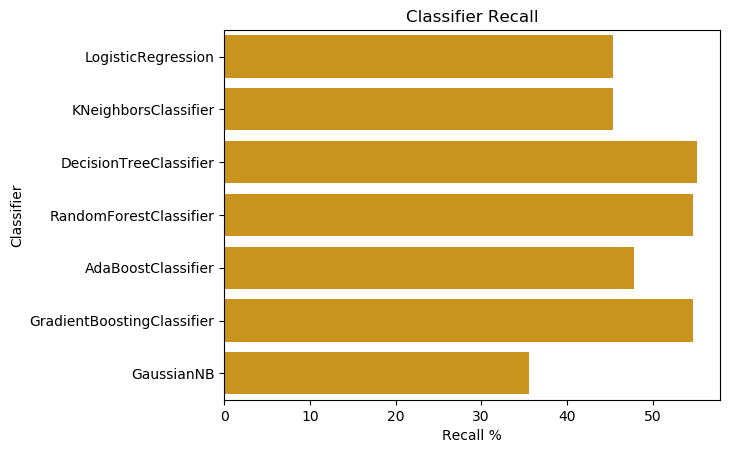

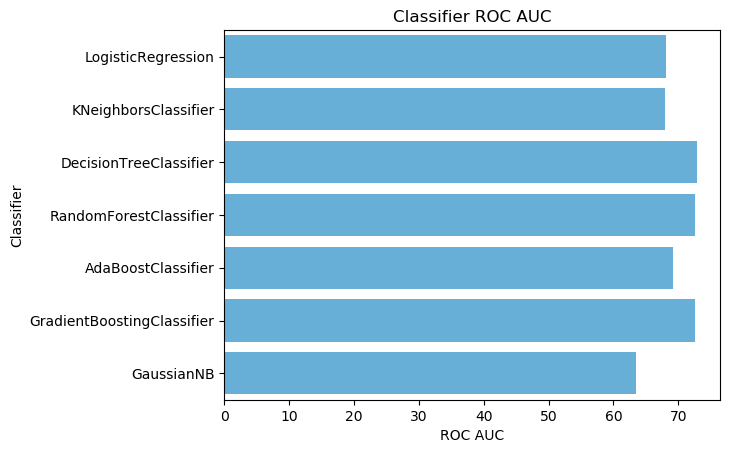

In [56]:
sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=log, color="#E69F00")

plt.xlabel('Recall %')
plt.title('Classifier Recall')
plt.show()


sns.set_color_codes("muted")
sns.barplot(x='ROC AUC', y='Classifier', data=log, color="#56B4E9")

plt.xlabel('ROC AUC')
plt.title('Classifier ROC AUC')

plt.show()

Confusion matrix
[[50567  8848]
 [ 3228  3319]]
Normalized confusion matrix
[[0.85 0.15]
 [0.49 0.51]]


<Figure size 3000x2000 with 0 Axes>

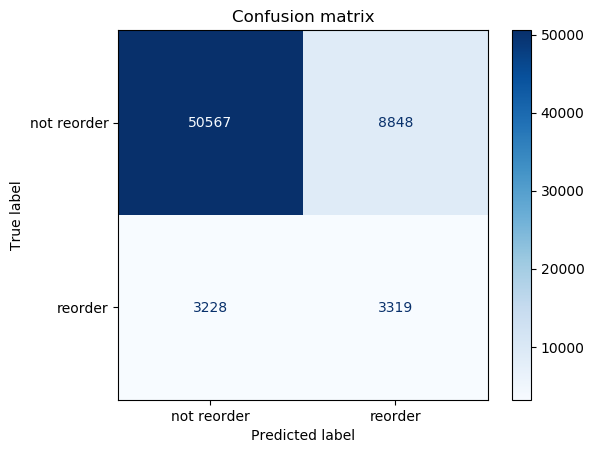

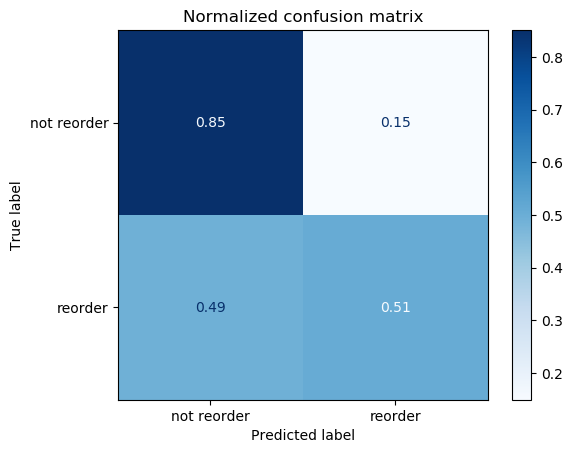

In [79]:
classifier = GaussianNB().fit(X_train, y_train)

np.set_printoptions(precision=2)
plt.figure(figsize=(15,10),dpi=200),
plt.style.use('default')

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=["not reorder","reorder"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix
[[51022  8393]
 [ 3282  3265]]
Normalized confusion matrix
[[51022  8393]
 [ 3282  3265]]


<Figure size 3000x2000 with 0 Axes>

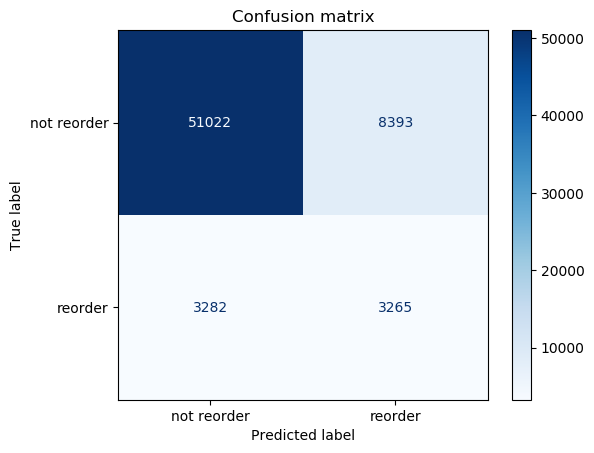

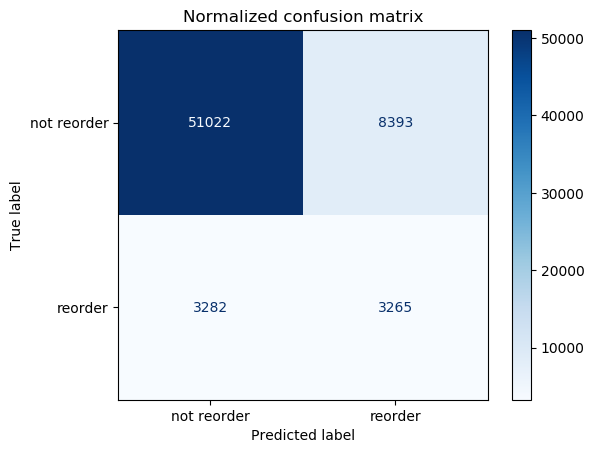

In [23]:
classifier = GaussianNB().fit(X_train, y_train)

np.set_printoptions(precision=2)
plt.figure(figsize=(15,10),dpi=200),
plt.style.use('default')

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=["not reorder","reorder"],
                                 cmap=plt.cm.Blues,values_format='.0f'
                                 )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [19]:
clf = DecisionTreeClassifier()
#Fit with all the training set
clf.fit(X_train, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

print("Feature Importance:")
for f in range(X.shape[1]):
    print("%s : (%f)" % (feature_names[f] , importances[indices[f]]))

Feature Importance:
user_product_total_orders : (0.171336)
product_total_orders : (0.140213)
product_avg_add_to_cart_order : (0.126124)
user_total_orders : (0.120731)
user_avg_cartsize : (0.109946)
user_total_products : (0.102445)
user_avg_days_since_prior_order : (0.091691)
user_product_avg_add_to_cart_order : (0.032577)
user_product_order_freq : (0.020085)
alcohol : (0.011021)
babies : (0.008479)
bakery : (0.007790)
beverages : (0.007329)
breakfast : (0.006121)
bulk : (0.005498)
canned goods : (0.005065)
dairy eggs : (0.004493)
deli : (0.004176)
dry goods pasta : (0.004113)
frozen : (0.004017)
household : (0.003689)
international : (0.003383)
meat seafood : (0.002271)
missing : (0.001877)
other : (0.001716)
pantry : (0.001205)
personal care : (0.001083)
pets : (0.000888)
produce : (0.000324)
snacks : (0.000310)


In [25]:
X=X[["user_product_total_orders","product_total_orders","product_avg_add_to_cart_order","user_total_orders",
     "user_avg_cartsize","user_total_products","user_avg_days_since_prior_order"]]
y= df_X.loc[:,"in_cart"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log = log.append(log_entry)
print("="*30)
round(log,3)

LogisticRegression
****Results****
Accuracy: 90.2080%
Precision: 7.4538%
Recall: 54.9550%
F1 Score: 13.1271%
ROC AUC: 72.8220%
Log Loss: 0.287
KNeighborsClassifier
****Results****
Accuracy: 88.6647%
Precision: 10.9974%
Recall: 30.3797%
F1 Score: 16.1489%
ROC AUC: 60.6083%
Log Loss: 2.242
DecisionTreeClassifier
****Results****
Accuracy: 84.6184%
Precision: 27.8601%
Recall: 25.1690%
F1 Score: 26.4463%
ROC AUC: 58.5625%
Log Loss: 5.312
RandomForestClassifier
****Results****
Accuracy: 90.2398%
Precision: 15.4575%
Recall: 52.8460%
F1 Score: 23.9187%
ROC AUC: 72.1019%
Log Loss: 0.392
AdaBoostClassifier
****Results****
Accuracy: 90.3732%
Precision: 8.7979%
Recall: 60.3141%
F1 Score: 15.3559%
ROC AUC: 75.5645%
Log Loss: 0.6694
GradientBoostingClassifier
****Results****
Accuracy: 90.5067%
Precision: 12.6317%
Recall: 60.4091%
F1 Score: 20.8944%
ROC AUC: 75.7768%
Log Loss: 0.2663
GaussianNB
****Results****
Accuracy: 88.4039%
Precision: 20.0397%
Recall: 35.2120%
F1 Score: 25.5427%
ROC AUC: 63.4002

,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,LogisticRegression,90.208,7.454,54.955,13.127,72.822,0.287
0,KNeighborsClassifier,88.665,10.997,30.380,16.149,60.608,2.242
0,DecisionTreeClassifier,84.618,27.860,25.169,26.446,58.563,5.312
0,RandomForestClassifier,90.240,15.457,52.846,23.919,72.102,0.392
0,AdaBoostClassifier,90.373,8.798,60.314,15.356,75.564,0.669
0,GradientBoostingClassifier,90.507,12.632,60.409,20.894,75.777,0.266
0,GaussianNB,88.404,20.040,35.212,25.543,63.400,0.628


In [20]:
target_count = df_X.in_cart.value_counts()
target_count

0    297467
1     32339
Name: in_cart, dtype: int64

In [21]:
# print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Class 0: 297467
Class 1: 32339
Proportion: 9.2 : 1
Percentage of Majority Class: 90.19


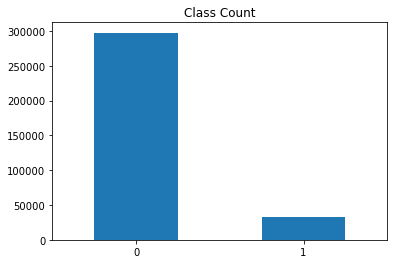

In [22]:
target_count.plot(kind='bar', title='Class Count', rot=0);

In [29]:
#Oversampling
#!pip install imblearn

In [30]:
#pip install -U imbalanced-learn 

In [23]:
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE

In [24]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X,y)

In [25]:
classifiers = [
    RandomForestClassifier()
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_resampled, y_resampled)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)
round(log,3)

RandomForestClassifier
****Results****
Accuracy: 99.9985%
Precision: 100.0000%
Recall: 99.9847%
F1 Score: 99.9924%
ROC AUC: 99.9924%
Log Loss: 0.04092


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,RandomForestClassifier,99.998,100.0,99.985,99.992,99.992,0.041


In [43]:
ros = RandomOverSampler(random_state=0)
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X,y)
classifiers = [
    
    KNeighborsClassifier()
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_smoted, y_smoted)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)
round(log,3)

KNeighborsClassifier
****Results****
Accuracy: 82.7052%
Precision: 99.4960%
Recall: 36.4134%
F1 Score: 53.3148%
ROC AUC: 68.1724%
Log Loss: 0.2917


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,KNeighborsClassifier,82.705,99.496,36.413,53.315,68.172,0.292


In [27]:
scores1 = cross_val_score(RandomForestClassifier(), X_smoted, y_smoted, cv=10, scoring="accuracy")
scores2 = cross_val_score(RandomForestClassifier(), X_smoted, y_smoted, cv=10, scoring="recall")
scores3 = cross_val_score(RandomForestClassifier(), X_smoted, y_smoted, cv=10, scoring="precision")
scores4 = cross_val_score(RandomForestClassifier(), X_smoted, y_smoted, cv=10, scoring="f1_macro")

print("Mean Accuracy: ", scores1.mean())
print("Mean Precision: ", scores3.mean())
print("Mean Recall: ", scores2.mean())
print("Mean F1 Score: ", scores4.mean())


Mean Accuracy:  0.9103974003396573
Mean Precision:  0.8948488271406921
Mean Recall:  0.9180520861863691
Mean F1 Score:  0.9091433778625978


In [44]:
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = clf.predict(X_smoted)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_smoted, y_predict), 
                                                     recall_score(y_smoted, y_predict)))

Default threshold:
Precision: 0.8385,   Recall: 0.9948


In [45]:
# using the new threshold of 0.06
y_predict = (clf.predict_proba(X_test)[:,1] > 0.07)
print("Threshold of 0.06:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Threshold of 0.06:
Precision: 0.2060,   Recall: 1.0000


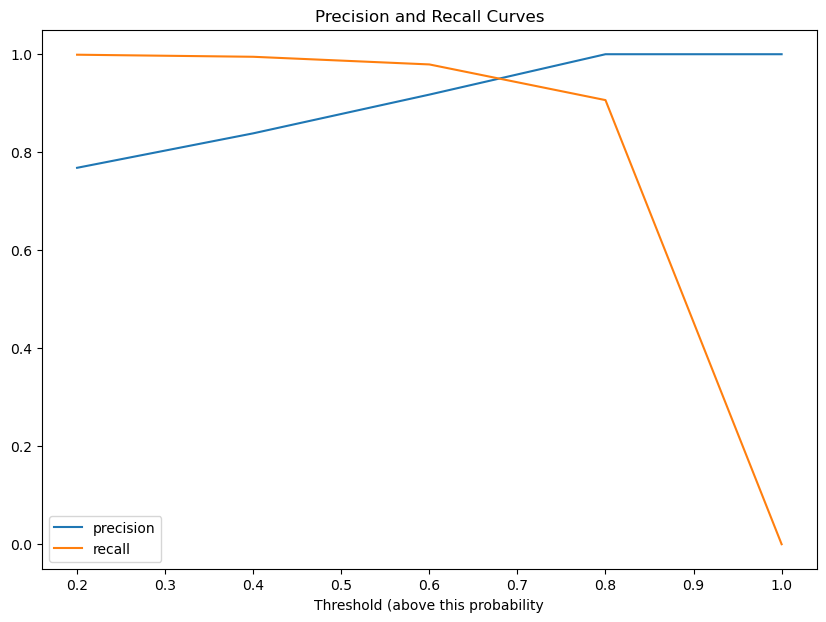

In [52]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score


precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_smoted, clf.predict_proba(X_smoted)[:,1] )

plt.figure(figsize=(10,7),dpi=100),
plt.style.use('default')
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability');
plt.title('Precision and Recall Curves');

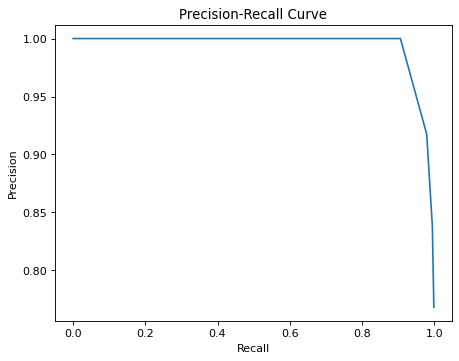

In [47]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

Confusion matrix
[[48040 11375]
 [   33  6514]]
Normalized confusion matrix
[[48040 11375]
 [   33  6514]]


<Figure size 3000x2000 with 0 Axes>

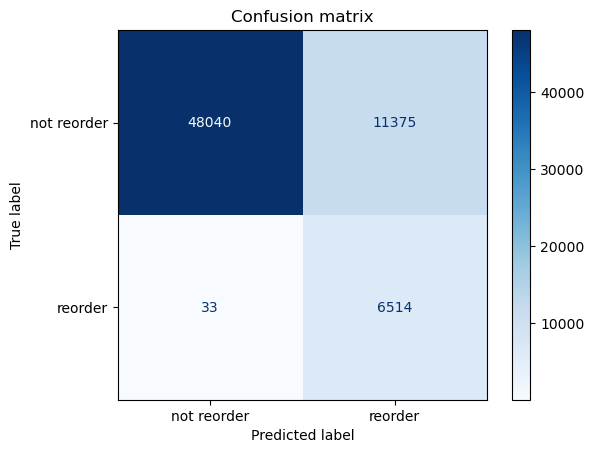

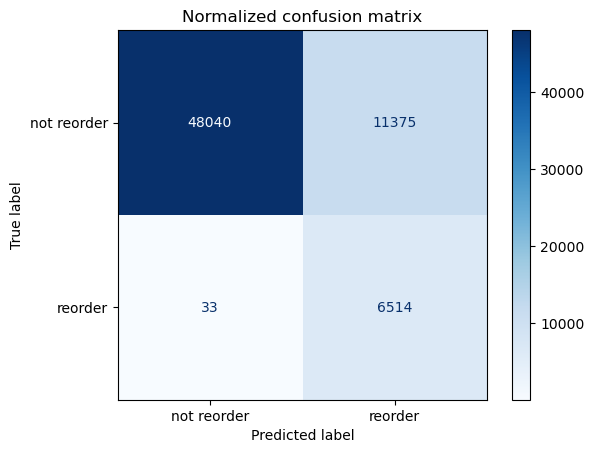

In [48]:
classifier = KNeighborsClassifier().fit(X_smoted, y_smoted)

np.set_printoptions(precision=2)
plt.figure(figsize=(15,10),dpi=200),
plt.style.use('default')

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=["not reorder","reorder"],
                                 cmap=plt.cm.Blues,values_format='.0f'
                                 )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix
[[58557   858]
 [ 6067   480]]
Normalized confusion matrix
[[0.99 0.01]
 [0.93 0.07]]


<Figure size 3000x2000 with 0 Axes>

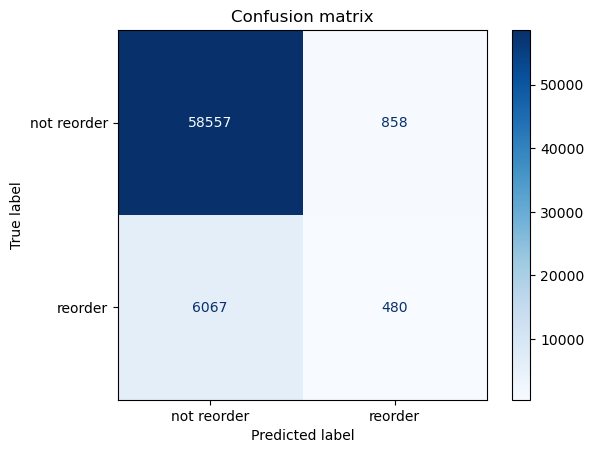

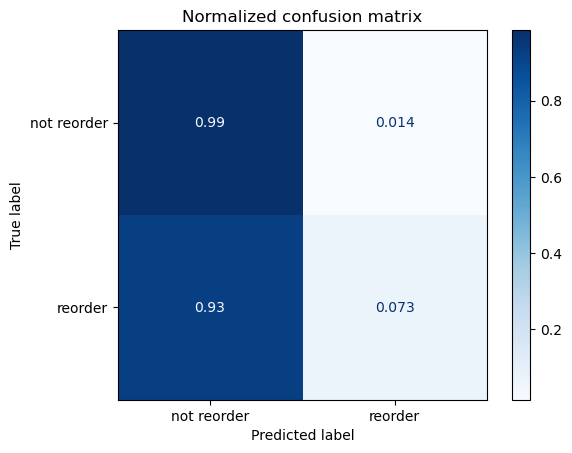

In [49]:
classifier = KNeighborsClassifier().fit(X_train, y_train)

np.set_printoptions(precision=2)
plt.figure(figsize=(15,10),dpi=200),
plt.style.use('default')

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=["not reorder","reorder"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()